# Exploring parameter space with Pypet

[lotka-volterra tutorial](https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html)

## A small example model: Lokta-Volterra (predator-prey equation)

---
### Sytem of ODEs:

$$
\left\{
    \begin{array}{ll}
        \displaystyle \frac{du}{dt} = au-buv \\
        \displaystyle \frac{dv}{dt} = -cv + dbuv
    \end{array}
\right.
$$

---

With variables:
* u: Number of preys
* v: Number of predator

And parameters:
* a: Natural growing rate of prey
* b: Natural dying rate of prey
* c: Natural dying rate of predator
* d: How many caught prey 'transform' into predator

In [1]:
# Centering Plot

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
.prompt 
    display:none;
}  
</style>
""")

### Implementation with scipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Definition of parameters
a = 1.
b = 0.1
c = 1.5
d = 0.75
def dX_dt(X, t=0):
    return np.array([ a*X[0] -   b*X[0]*X[1] ,
                     -c*X[1] + d*b*X[0]*X[1] ])


In [3]:
from scipy import integrate
t = np.linspace(0, 15,  1000)              # time
X0 = np.array([10, 5])                     # initial conditions
X, infodict = integrate.odeint(dX_dt, X0, t, full_output=True)
infodict['message']


'Integration successful.'

Text(0.5, 1.0, 'Evolution of predators and preys populations')

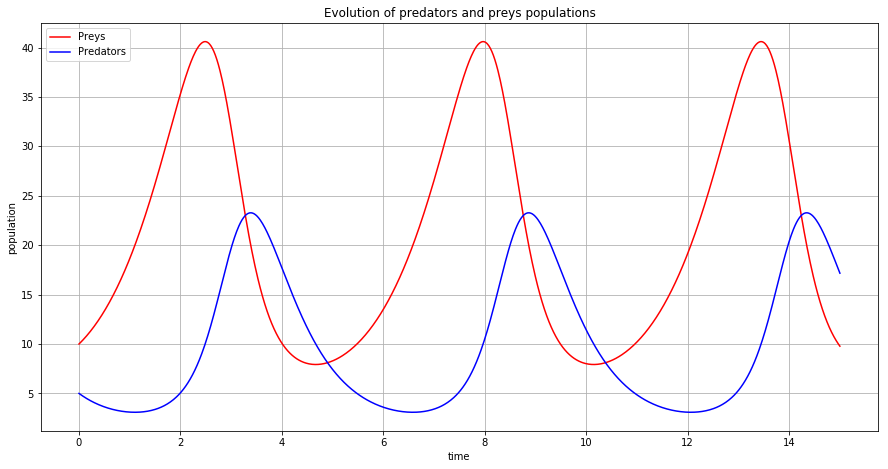

In [4]:
preys, predators = X.T
f1 = plt.figure(figsize=(15,7.5))
f1.gca().plot(t, preys, 'r-', label='Preys')
f1.gca().plot(t, predators  , 'b-', label='Predators')
f1.gca().grid()
plt.legend(loc='upper left')
plt.xlabel('time')
plt.ylabel('population')
plt.title('Evolution of predators and preys populations')

## Space parameter exploration

In [5]:
TIME = np.linspace(0, 15,  1000)
INITIAL_STATE = np.array([10, 5])    

def lokta_volterra_model(a, b, c, d):
    dX_dt = lambda X, t:  np.array([ a*X[0] -   b*X[0]*X[1] ,
                                 -c*X[1] + d*b*X[0]*X[1] ])
    X, infodict = integrate.odeint(dX_dt, INITIAL_STATE, TIME, full_output=True)
    return X.T
    

In [6]:
from pypet import Environment, Trajectory
from pypet.utils.explore import cartesian_product

def pypet_wrapper(traj):
    result = lokta_volterra_model(traj.a, traj.b, traj.c, traj.d)
    traj.f_add_result('result', result, comment='Result from `lokta_volterra`')
    return result
    

In [7]:
env = Environment(trajectory='Lokta_Volterra',
                 multiproc=True,
                 ncores=8,
                 overwrite_file=True,
                 automatic_storing=True)

traj = env.trajectory
traj.f_add_parameter('a', np.float64(0))
traj.f_add_parameter('b', np.float64(0))
traj.f_add_parameter('c', np.float64(0))
traj.f_add_parameter('d', np.float64(0))

traj.f_explore(cartesian_product({'a': np.arange(1,3, 0.3),
                                  'b': np.arange(1,3, 0.3),
                                  'c': np.arange(1,3, 0.3),
                                  'd': np.arange(1,3, 0.3)}))

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/Users/florian/code/mosaic/mosaic-commons/notebook/hdf5/Lokta_Volterra.hdf5`.
MainProcess pypet.storageservice.HDF5StorageService INFO     You specified ``overwrite_file=True``, so I deleted the file `/Users/florian/code/mosaic/mosaic-commons/notebook/hdf5/Lokta_Volterra.hdf5`.
MainProcess pypet.environment.Environment INFO     Environment initialized.


In [8]:
import warnings
import time
warnings.simplefilter(action='ignore', category=FutureWarning) #remove numpy FutureWarning

start = time.time()
results = env.run(pypet_wrapper)
print(time.time()-start)

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `Lokta_Volterra`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `Lokta_Volterra`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`Lokta_Volterra`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `Lokta_Volterra`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `Lokta_Volterra`.
MainProcess pypet.environment.Environment INFO     

111.14367580413818


## Postprocess

In [9]:
import pandas as pd

a_range = traj.par.f_get('a').f_get_range()
b_range = traj.par.f_get('b').f_get_range()
c_range = traj.par.f_get('c').f_get_range()
d_range = traj.par.f_get('d').f_get_range()

runs = len(results)

df = pd.DataFrame(index=np.arange(runs), columns=['a', 'b', 'c', 'd', 'results'])


list_res = []
for result_tuple in results:
    res = result_tuple[1]
    nested_df = pd.DataFrame(index=np.arange(len(TIME)), columns=['time', 'prey', 'predator'])

    nested_df['time'] = TIME
    nested_df['prey'] = res[0]
    nested_df['predator'] = res[1]
    
    list_res.append(nested_df)



df = pd.DataFrame({'a': a_range, 'b': b_range, 'c': c_range, 'd': d_range, 'results': list_res})

traj.f_add_result('dynamic', dynamic=df,
                  comment='Contains a pandas data frame with all results.')

<Result results.dynamic (`Contains a pandas data frame with all results.`): dynamic=        a    b    c    d                             ...>

## Storing results

In [10]:
env.trajectory.f_store(env.trajectory.f_get('dynamic'))
traj.f_store()

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `Lokta_Volterra`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `Lokta_Volterra`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Start storing Trajectory `Lokta_Volterra`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `config`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `parameters`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Storing branch `results`.
/Users/florian/Dev/miniconda3/envs/cellfem/lib/python3.7/site-packages/pypet/storageservice.py:3967: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['results']]

  self._prm_store_from_dict(fullname, store_dict, _hdf5_group, store_flags, kwargs)
MainPr

## Loading trajectory

In [11]:
traj = Trajectory(filename='hdf5/Lokta_Volterra.hdf5')

traj.f_load(name='Lokta_Volterra', load_parameters=2, load_results=2)
#level 0: no data is loaded
#level 1: container without data is loaded (skeleton)
#level 2: container with data is loaded

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `hdf5/Lokta_Volterra.hdf5`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `Lokta_Volterra`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `2`.


In [12]:
print(traj.f_get('dynamic'))
loaded_df = traj.results.dynamic

Result results.dynamic (`Contains a pandas data frame with all results.`): dynamic=        a    b    c    d                             ...


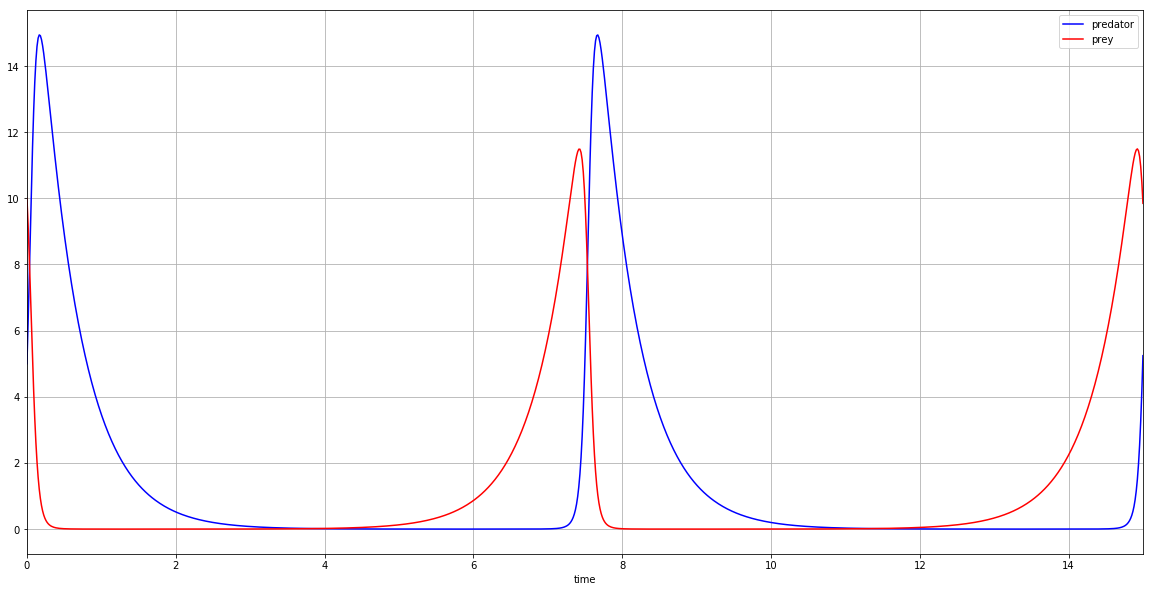

In [13]:
fig1 = plt.figure(figsize=(20,10))
loaded_df.loc[1100, 'results'].plot(kind='line',x='time', y='predator', color='blue', grid=True, ax=fig1.gca())
loaded_df.loc[1100, 'results'].plot(kind='line',x='time', y='prey', color='red', grid=True, ax=fig1.gca())

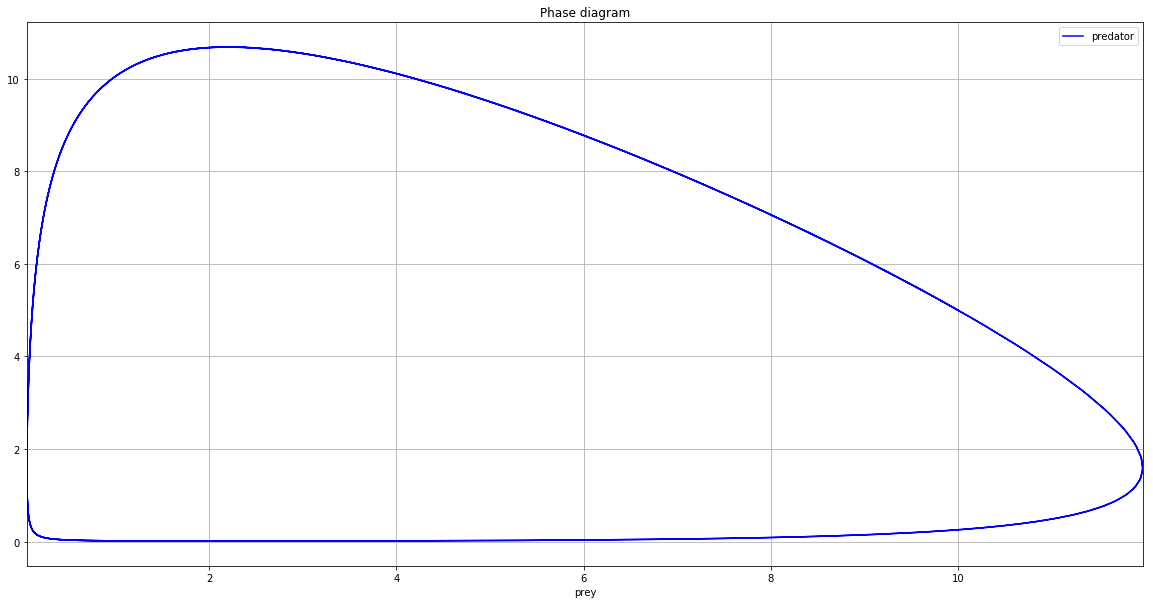

In [14]:
fig2 = plt.figure(figsize=(20,10))
loaded_df.loc[714, 'results'].plot(kind='line',x='prey', y='predator', color='blue', grid=True, ax=fig2.gca(),
                                  title='Phase diagram')